In [1]:
# analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=3)
warnings.filterwarnings("ignore")

# missings (imputer)
# from sklearn.impute import SimpleImputer, KNNImputer

# interacciones
from sklearn.preprocessing import PolynomialFeatures

# transformaciones
from sklearn.compose import ColumnTransformer
# - variab numéricas
from sklearn.preprocessing import RobustScaler # MinMaxScaler, StandardScaler, Normalizer, Binarizer 
# from sklearn.preprocessing import PowerTransformer, BoxCox
# - variab categ
from sklearn.preprocessing import OneHotEncoder # LabelEncoder, OrdinalEncoder

# feature selection
from sklearn.feature_selection import f_classif # chi2
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import RFE, RFECV
# from sklearn.decomposition import PCA

# algoritmos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier # red neuronal

# bagging
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier

# boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# import xgboost as xgb

# model selection
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.pipeline import Pipeline #make_pipeline
from sklearn.model_selection import GridSearchCV # RandomizedSearchCV
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, ParameterGrid

# Técnicas de evaluación
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, RocCurveDisplay

In [2]:
# semilla de aleatorización

seed = 99

In [3]:
data = pd.read_csv('Datasets/datos_procesados.csv')

print(f'Número de filas: {data.shape[0]}, Númerode columnas:{data.shape[1]}')

Número de filas: 4687, Númerode columnas:24


In [4]:
# Separar en train y test
X_train = data[data['Dataset'] == 'train'].drop(['Dataset'], axis=1)
X_test = data[data['Dataset'] == 'test'].drop(['Dataset'], axis=1)

# variable objetivo (.pop elimina la col de X, que también es un paso necesario)
y_train = X_train.pop('Hazardous')
y_test = X_test.pop('Hazardous')

In [5]:
# SMOTE

# Probaremos a obtener el mejor modelo tanto con los train_data desbalanceados como balanceados con smote

categ_index = X_train.columns.get_loc('Orbit Uncertainity (categ)')

smote_nc = SMOTENC(categorical_features=[categ_index], # hay que indicarle cuál es la variab categ en el dataset que se va a transformar
             random_state=seed)

X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

# Observamos el resultado del rebalanceo:
np.array(np.unique(y_train_resampled, return_counts=True)).T

array([[   0, 3145],
       [   1, 3145]], dtype=int64)

Teoría:

Parámetros para clasificación binaria con SVM (SVC) en sklearn:

* **C**: Parámetro de regularización (relacionado con el concepto de soft margin del SVM).

    Controla la penalización por errores de clasificación. Un valor más alto de C indica un mayor énfasis en clasificar correctamente cada punto de datos del conjunto de entrenamiento. Un valor más bajo de C permite una mayor flexibilidad y puede resultar en una frontera de decisión más suave. El rango típico de valores para C es 0.1 a 1000 (a mayor C, mayor sobreajuste).

* **kernel**: Función de kernel utilizada para transformar los datos de entrada en un espacio de mayor dimensión donde sea más fácil encontrar un hiperplano de separación lineal. Ejemplos:
    - 'linear'
    - 'poly' (polinomial)
    - 'rbf': función de base radial (Radial Basis Function)
    - 'sigmoid'

* **gamma**: Parámetro para los kernels 'rbf', 'sigmoid', y 'poly' (parám de las expresiones matemáticas de esas funciones).

    Controla la influencia de cada punto de datos en la formación de la frontera de decisión. Valores más altos de gamma dan como resultado una frontera de decisión más ajustada que se adapta a puntos de datos individuales, mientras que valores más bajos de gamma dan como resultado una frontera de decisión más suave y generalizada. El rango típico de valores para gamma es 0.1 a 10.

## 1) SVC - Kernel polinomial (incl. lineal)

In [6]:
import time
start_time = time.time()

# Elegir el algoritmo
model = SVC(kernel='poly',
            class_weight='balanced',
            random_state=seed)

# Definir variabs numéricas y categóricas
scaler_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categ_features = [feature for feature in X_train.columns if feature not in scaler_features]

col_transformer = ColumnTransformer(
    [
    ('encoder', OneHotEncoder(drop=["3-9"]), ['Orbit Uncertainity (categ)']),
    ('scaler', RobustScaler(), scaler_features)
    ], remainder='passthrough')

# # Definir instancia SMOTENC (se puede o bien definir fuera y pasar X_train_resampled, o bien definir aquí y pasar X_train)
# categ_index = X_train.columns.get_loc('Orbit Uncertainity (categ)')
# smote_nc = SMOTENC(categorical_features=[categ_index], # hay que indicarle cuál es la variab categ en el dataset que se va a transformar
#              random_state=seed)

# # Pipeline 1
# pipe = Pipeline([
# #         ('smote_nc', smote_nc), # quitarlo si class_weight='balanced'
#         ('column_transform', col_transformer),
#         ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # añadir interacciones
#         ('algorithm', model)        
# ])

# # Tuneado del modelo:
# # malla de paráms
# parametros = {
#     "algorithm__C": [0.1, 1, 10, 100],
#     "algorithm__gamma": [0.1, 1, 10],
#     "algorithm__degree": [1, 2], # 3; degree=1 es kernel lineal
# }

# Repeated cross_val (stratified)
# cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_technique = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)
    
# # combinamos todo
# gsearch = GridSearchCV(estimator=pipe, cv=cv_technique, param_grid=parametros, scoring='f1') # (*)

# # buscamos el mejor modelo
# # opción a) sin resample y con class_weight='balanced':
# grid_model = gsearch.fit(X_train, y_train)

# # opción b) con resample (SMOTE)
# # grid_model = gsearch.fit(X_train_resampled, y_train_resampled)

# print("Best CV score:", grid_model.best_score_)

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")


Tiempo de ejecución: 0.0010008811950683594 segundos


In [7]:
# # Mejor estimador
# grid_model.best_estimator_.named_steps['algorithm']

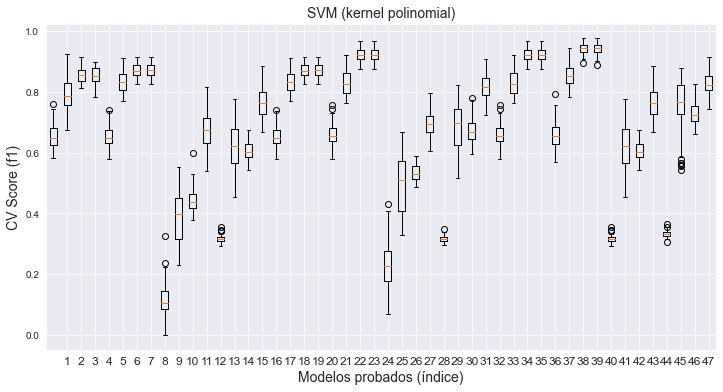


Tiempo de ejecución: 536.3568840026855 segundos


In [8]:
# Pipeline 2: feature selection (cross_val_score)
# Repetir la cross_val, pero guardando los scores para poder representarlos y
# además, haciendo feature selection basada en f_classif

import time
start_time = time.time()

pipe_fs = Pipeline([
#         ('smote_nc', smote_nc), # quitarlo si class_weight='balanced'
        ('column_transform', col_transformer),
        ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # añadir interacciones
        ('feature_selection', SelectKBest(score_func=f_classif)), # k = número de variabs a seleccionar
#         ('algorithm', grid_model.best_estimator_.named_steps['algorithm'])   
        ('algorithm', model)
]) # importante: meter el mejor algorithm obtenido antes

parametros_fs = {
    "feature_selection__k": [3,4,5,6],
    "algorithm__C": [0.1, 1, 10],
    "algorithm__gamma": [0.1, 1],
    "algorithm__degree": [1, 2], # 3; degree=1 es kernel lineal
}

# Cambiar el formato de la malla de parámetros para poder usarlos en el bucle for
grid_params = list(ParameterGrid(parametros_fs)) # lista de diccionarios

cv_scores = []
for params in grid_params:
    # Configurar los parámetros del pipeline
    pipe_fs.set_params(**params)
    
    # Calcular los scores
    scores = cross_val_score(pipe_fs,
                             X_train, y_train, # X_train_resampled, y_train_resampled
                             cv=cv_technique, scoring='f1')
    cv_scores.append(scores)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(cv_scores)
plt.title('SVM (kernel polinomial)', fontsize=14)
plt.xlabel('Modelos probados (índice)', fontsize=14)
plt.ylabel('CV Score (f1)', fontsize=14)
plt.xticks(range(2, len(cv_scores)+1), fontsize=12) # no consigo poner el xtick = 0
plt.show()

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")

In [26]:
# Comparar mejores
print(grid_params[22])
print(grid_params[34])
print(grid_params[38])

{'algorithm__C': 1, 'algorithm__degree': 1, 'algorithm__gamma': 1, 'feature_selection__k': 5}
{'algorithm__C': 10, 'algorithm__degree': 1, 'algorithm__gamma': 0.1, 'feature_selection__k': 5}
{'algorithm__C': 10, 'algorithm__degree': 1, 'algorithm__gamma': 1, 'feature_selection__k': 5}


In [21]:
# El mejor modelo es:
modelo_optimo = 22 # indicar nº óptimo

# Configura el pipeline con los parámetros deseados
selected_params = grid_params[modelo_optimo]
pipe_fs.set_params(**selected_params)

# Ajusta el modelo
selected_model = pipe_fs.fit(X_train, y_train)
selected_model

Pipeline(steps=[('column_transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(drop=['3-9']),
                                                  ['Orbit Uncertainity '
                                                   '(categ)']),
                                                 ('scaler', RobustScaler(),
                                                  ['Est Dia in M(max)',
                                                   'Relative Velocity km per '
                                                   'sec',
                                                   'Miss Dist.(Astronomical)',
                                                   'Minimum Orbit Intersection',
                                                   'Eccentricity',
                                                   'Semi Major Axis',
                                                   'Inclination',
                                                   'Asc Node Longitude...
                                                   'Semi Major Axis_log',
                                                   'Inclination_squared',
                                                   'Perihelion '
                                                   'Distance_squared',
                                                   'Mean Anomaly_raiz2',
                                                   'Mean Motion_cuarta',
                                                   'Perihelion '
                                                   'Arg_squared'])])),
                ('polynomial',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('feature_selection', SelectKBest(k=5)),
                ('algorithm',
                 SVC(C=1, class_weight='balanced', degree=1, gamma=1,
                     kernel='poly', random_state=99))])

In [22]:
selected_model.named_steps['algorithm'].get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 1,
 'gamma': 1,
 'kernel': 'poly',
 'max_iter': -1,
 'probability': False,
 'random_state': 99,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [23]:
# Variables seleccionadas:

ct_names = selected_model.named_steps['column_transform'].get_feature_names_out()
poly_names = selected_model.named_steps['polynomial'].get_feature_names_out(input_features=ct_names)
select_names = selected_model.named_steps['feature_selection'].get_feature_names_out(input_features=poly_names)

print(f"Las {len(select_names)} variabs seleccionadas son:")
[i for i in select_names]

Las 5 variabs seleccionadas son:


['scaler__Minimum Orbit Intersection',
 'scaler__Est Dia in M(max)_raiz2',
 'encoder__Orbit Uncertainity (categ)_0 scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max) scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max)_raiz2 scaler__Minimum Orbit Intersection_log']

El valor de f1 score es: 
 0.928
Otros estadísticos del test: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       787
           1       0.88      0.99      0.93       151

    accuracy                           0.98       938
   macro avg       0.94      0.98      0.96       938
weighted avg       0.98      0.98      0.98       938



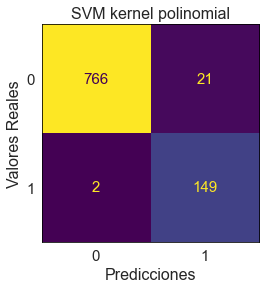

In [24]:
# Evalúa el mejor modelo en tus datos de prueba
y_pred = selected_model.predict(X_test)

# Calcular la precisión de las predicciones en el conjunto de prueba
print(f"El valor de f1 score es: \n {f1_score(y_test, y_pred).round(3)}")
print(f"Otros estadísticos del test: \n {classification_report(y_test, y_pred)}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap='viridis', values_format='d', colorbar=False)
ax.grid(False) # Deshabilitar el grid de fondo

# plt.title('Matriz de confusión', fontsize=18) # Cambiar tamaño del título
ax.spines[['bottom','top','left','right']].set_color('black')
plt.title('SVM kernel polinomial', fontsize=16)
plt.xlabel('Predicciones', fontsize=16)
plt.ylabel('Valores Reales', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for text in ax.texts:
    text.set_fontsize(15)
plt.show()

In [28]:
import pickle

# Guarda los datos de puntuaciones
with open('cv_scores_model8.pkl', 'wb') as f:
    pickle.dump(cv_scores[modelo_optimo], f)